# Crypto-currency Price Prediction using LSTM (Long-Short Term Memory) Model

We will **predict the price of the next day using the data of past few days**(exact number of past few days depends on the data). <br>Suppose we find that our price is highly correlated to the prices of last 7 days. Then, we will use the price of last 7 days to predict the price of tomorrow/next day.<br>
But for predicting the price of day after tomorrow, we will be needing the price of tomorrow. This problem is not considered in this notebook, cause this notebook was created with the aim to predict the price of tomorrow.<br><br>
But we can still solve this problem using two ways:<br><br>
1. Directly training the model to predict the price of day after tomorrow rather than tomorrow, using the past data. <br><br>
2. Using the predicted price of tomorrow as historical data, and using it to predict the price of day after tomorrow, and adding this to historical dataset, to predict the price of next day, and so on.<br><br>

_Notes - _<br>
_1. The error will be a bit greater in the above methods_<br>
_2. Past data and historical data are used synonymously_


Notebook is divided into Sections :<br>
1. Data Import<br>
2. Understanding the distribution of the data<br>
3. Data Transformation<br>
4. Model Building and Training<br>
6. Cross-Validating the model<br><br>
7. Notes<br>
8. Playground

In [2]:
# Importing the required libraries
import pandas  as pd 
import numpy as np
import matplotlib.pyplot as plt 
import pandas_datareader as web
import datetime as dt 
import yfinance as yf
import sktime
import pandas_datareader.data as pdr
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from tensorflow.keras.layers import Dense, Dropout, LSTM, LayerNormalization,Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend
from pycaret.regression import *

## Data Import

Choose the cryptocurrency we want to predict, and the period of time whose data we want to collect.

In [3]:
crypto_currency = 'BNB'
against_currency ='USD'
start = dt.datetime(2021,1,1)
end = dt.datetime.now()-dt.timedelta(days=50)

Extracting the above chosen data using Yahoo-Finance API

In [4]:
yf.pdr_override()
data = pdr.get_data_yahoo("BNB-USD", start, end)
# Importing the extracted data in PyCaret
df = setup(data,target = "Close",ignore_features=["Volume","Adj Close"], use_gpu=True,imputation_type='iterative', feature_ratio=True, feature_interaction=True, normalize=True, transform_target=True)           

,Description,Value
0,session_id,2870
1,Target,Close
2,Original Data,"(140, 6)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(97, 4)"


## Understaning the distribution of the data

In [5]:
# Distribution of our target variable -> Close
# from scipy.special import boxcox1p
# plt.plot(np.array(final_data["Close"]))

### Checking if our series is affected by past values

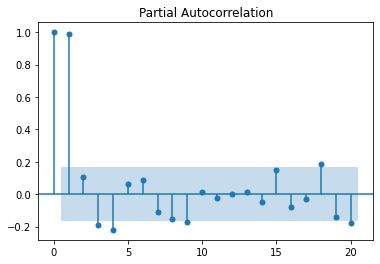

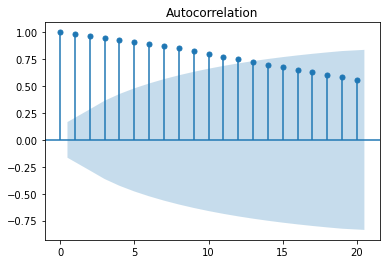

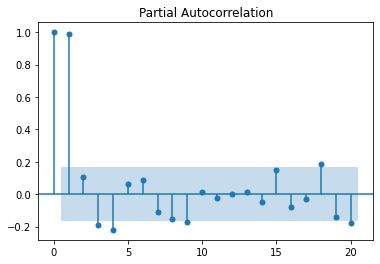

In [6]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Close'], lags=20)
plot_pacf(data['Close'], lags=20)

From the above plots, lags are highly correlated to the value at hand. This will be useful while preparing the data for the model, and we will pass tha value, based on the above Observation.

From here, I tried various plots of interactions and transformations of the attributes.

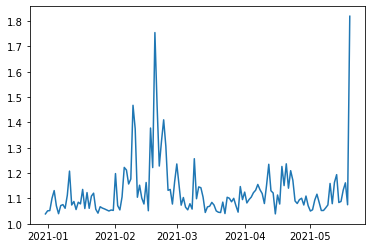

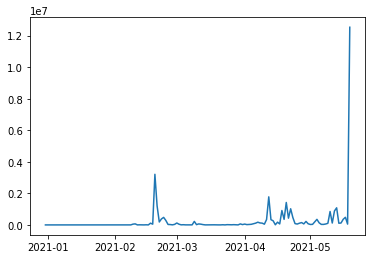

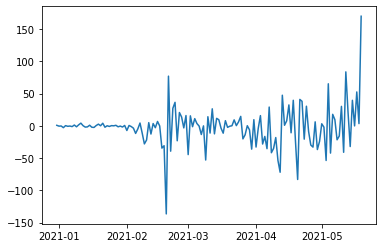

In [7]:
plt.figure() 
plt.plot(data["High"]/data["Low"])
plt.figure()
plt.plot((np.power(data["High"]-data["Low"],3)))
plt.figure()
plt.plot(data["Open"]-data["Close"])

## Data Cleaning and Transformation

In [8]:
print(data.isnull().sum())     # checking for missing values

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Section for trying sktime library, if it can help us transform the Time-Series

In [9]:
# from sktime.utils.plotting import plot_series
# from sktime.transformations.panel.rocket import Rocket
# y = data["Close"]
# x = data[data.columns]
# x.drop(["Close","Volume"],axis=1,inplace=True)
# plot_series(data["Close"])
# rocket = Rocket()
# rocket.fit(np.array(x))
# x_t = rocket.transform(np.array(x))

### Defining methods for transforming time-series data

In [10]:
def difference(data, interval=1):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]
def invert_difference(orig_data, diff_data, interval=1):
	return [diff_data[i-interval] + orig_data[i-interval] for i in range(interval, len(orig_data))]

from scipy.stats import boxcox
# fd =(boxcox1p(final_data["Close"]))#*np.log(boxcox1p(final_data["Close"],-1))
# plt.plot(fd)

The idea here is to store the data at each step, without losing/replacing it. <br>Thus, creating new variables wherever required to store the new/transformed data in the new variable.

Adding new Attributes to the dataset, based on the plots and Observations of the previous section.<br>Some Transformations are commented, cause they were not a suitable fit, but might be useful later.

In [11]:
final_data = pd.DataFrame()
final_data["Close_Open"] = data['Close']-data['Open']
final_data["High_Low"] = data['High']-data['Low']
final_data['t1'] = (np.power(data["High"]-data["Low"],3))
final_data['Close'] = data['Close']

final_data.head()
# scaler = PowerTransformer(method="yeo-johnson", standardize=True)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_data.values)
# logged_data = np.log10(data['Close'])
# scaled_data, lambda_data = (boxcox(data['Close']))#difference(logged_data).to_numpy()
# new = difference((data['Close'],1)
# scaled_data = pd.Series(scaled_data)

### Preparing the data

The data is in 3 dimensions.<br> <br>First Dimension - It denotes the number of observations. Each value of this dimension (the values are in 2-dimension) is the input to our model, corresponding to which we have final value.<br> <br>Second Dimension - It denotes the past values, which we will be using to predict. The length of this dimension, shows how many past values/observations we will be feeding to our model.<br> <br>Third Dimension - It shows the attributes that we think affect our future value or might increase the performance of our model.<br><br> Suppose _i_,_j_,_k_ as indices and _data_ as our final 3-Dimensional Dataset. Then _data\[i\]_ , denotes a single 2-D observation consisting of values of previous days. Then, _data\[i\]\[j\]_ denotes a 1-D value of one of the previous days from our previous  2-D _data\[i\]_. _data\[i\]\[j\]\[k\]_ denotes value of one attribute from our previous 1-D _data\[i\]\[j\]_ which denoted all the attributes of one of the past days. 

**_Note to self : Might upload a image for better understanding of the readers._**

In [12]:
# Preparing the Data
prediction_days = 7
future_days=0
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_days):
    x_train.append(scaled_data[x-prediction_days:x])
    y_train.append(scaled_data[x+future_days,scaled_data.shape[1]-1])
x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1],1))
# range(prediction_days, len(scaled_data))x_train
x_train.shape

(133, 7, 4)

## Model Building and Training

In [13]:
# custom metric for our model, only to monitor our model while training
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

Building LSTM using TensorFlow. At the end compiling and training the model. <br><br>
The hyperparameters need to be more precisely tuned, but so far they seem to work fine. We can add more layers to improve the model, and this is an **endless process**.

In [44]:
#creating neural netowrk
# from attention_decoder import AttentionDecoder

model = Sequential()                # could make units 50, for better prediction
# model.add(LayerNormalization())     # Normalizing the input data 
# First LSTM layer
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2]),activation="relu",unroll=True))
# model.add(Dropout(0.1))    # Removing some of the data from the previous layer to avoid overfitting
model.add(BatchNormalization())
model.add(LSTM(units=50, activation="relu",unroll=True,return_sequences=True))#, return_sequences=True))    # Second LSTM Layer
# model.add(Dropout(0.1))
model.add(Activation(activation="relu"))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(Activation(activation="relu"))
model.add(BatchNormalization())
model.add(LSTM(units=50))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
## 
# model.add(Dropout(0.1))
# model.add(LSTM(units=50,activation="relu"))
# model.add(Dense(units=500, activation="relu"))
# model.add(Dropout(0.2))

model.add(Dense(units=1))  # Final LSTM Layer of unit=1, cause we have just one Output, that is, Closing Price
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1),metrics=[rmse])   # Compiling, optimizer and loss can be changed to optimize the model for our specific purpose
model.fit(x_train,y_train, epochs=500, batch_size=10)

 0.0980
Epoch 297/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0079 - rmse: 0.0997
Epoch 298/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0100 - rmse: 0.1143
Epoch 299/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0084 - rmse: 0.0846
Epoch 300/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0130 - rmse: 0.1293
Epoch 301/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0119 - rmse: 0.1175
Epoch 302/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0078 - rmse: 0.0989
Epoch 303/500
14/14 [==============================] - 0s 31ms/step - loss: 0.0112 - rmse: 0.1219
Epoch 304/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0092 - rmse: 0.1079
Epoch 305/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0082 - rmse: 0.1056
Epoch 306/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0068 - rmse: 0.0906
Epoch 307/50

## Cross-Validating the model

Extracting the data for test dataset, and performing the same operation as performed on training data. And, combining the dataset, and from this combined dataset extracting the data which will be given as input to the model.<br><br>
The reason for the above process is, to predict the first few predictions, we also need past data that is available in training dataset, so we combine that required data with our test data and then pass it to the model.
         

In [45]:
test_start = dt.datetime.now()-dt.timedelta(days=50)
test_end = dt.datetime.now()

test_data = pdr.get_data_yahoo("BNB-USD", test_start, test_end)

final_test = pd.DataFrame()
final_test['Close_Open'] = test_data['Close'] - test_data['Open']
final_test['High_Low'] = test_data['High'] - test_data['Low']
final_test['t1'] = np.power(test_data["High"]-test_data["Low"],3)
final_test['Close'] = test_data['Close']

total_dataset = pd.concat((final_data,final_test),axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data)-prediction_days:]
# model_inputs=difference(np.log10((model_inputs))).to_numpy()
# model_inputs = model_inputs
model_inputs = scaler.transform(model_inputs)
actual_prices = (model_inputs[prediction_days:,scaled_data.shape[1]-1])#difference(np.log10((test_data['Close']))).to_numpy()



x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x])
x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))


[*********************100%***********************]  1 of 1 completed


Predicting the prices using x_test, and comparing it with the actual prices

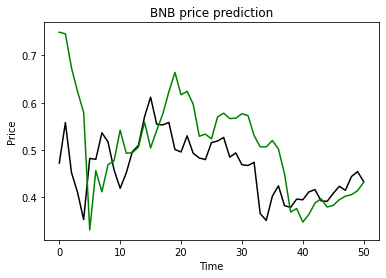

In [46]:
prediction_prices = model.predict(x_test)
# prediction_prices = scaler.inverse_transform(prediction_prices)
# prediction_prices = scaler.inverse_transform(prediction_prices) 
plt.plot(actual_prices,color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.legend(loc='lower left')
plt.show()

Comparing the RMSE scores of predicting on Training dataset vs Test Dataset.This will help us to check overfitting and improving our models.

Test Data (RMSE) :  0.07584439218044281
Train Data (RMSE) :  0.03595810383558273


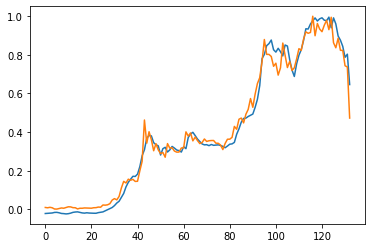

In [47]:
# # Predict Next Day
# real_data = [model_inputs[len(model_inputs) +1 - prediction_days: len(model_inputs) + 1,0]]
# real_data = np.reshape(real_data,-1)
# real_data = np.reshape(real_data, (real_data.shape))
# prediction = model.predict(real_data)
# prediction = scaler.inverse_transform(prediction)
# print()
# (prediction_prices)
# plottiong training dataset  
test = model.evaluate(x_test,actual_prices,verbose=0)[1];
train = model.evaluate(x_train,y_train,verbose=0)[1];
print("Test Data (RMSE) : ", test);
print("Train Data (RMSE) : ", train);
plt.plot(model.predict(x_train))
plt.plot(y_train)

## Notes
for 1000 epochs, model is overfitting, 500 seems fine to me. Might decrease the epochs from 500
Optimizer and loss are alright to i guess.
activation function is next (marked in to-do in github projects)

## Playground for trying various combination before they are finally incorporated into the notebook

In [67]:
re = data['Close']).reshape(-1,1)
data2 = scaler.fit_transform(re)
# data2[3:]
plt.plot(difference(np.log10((data2))).to_numpy(),color='black', label='Actual Prices')

SyntaxError: unmatched ')' (<ipython-input-67-9cbb75c363d4>, line 1)

In [ ]:
pd.Series(np.array(boxcox(data['Close'])))

In [ ]:
# plt.plot(data['Open'])
# plt.plot(data['Close'])
plt.plot(data['High'] - data['Low'])
plt.plot(data['Close'] - data['Open'])
# plt.plot(data['Close'] - data['High'])
# plt.plot(data['Close'] - data['Low'])
# plt.plot(data['Low'])

In [ ]:
# #creating neural netowrk  Good Model
# model = Sequential()                # could make units 50, for better prediction
# model.add(LSTM(units=500, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]), activation="relu" ))
# # model.add(Dropout(0.2))
# model.add(LSTM(units=500, activation="relu"))
# # model.add(Dropout(0.2))
# # model.add(LSTM(units=50,activation="relu"))
# # model.add(Dense(units=100, activation="relu"))
# # model.add(Dropout(0.2))

# model.add(Dense(units=1,activation="relu"))
# model.compile(optimizer='adam', loss='mean_squared_error',metrics=[rmse])
# model.fit(x_train,y_train, epochs=100, batch_size=10)

In [ ]:
# best model till now
model = Sequential()                # could make units 50, for better prediction
# model.add(LayerNormalization())     # Normalizing the input data 
# First LSTM layer
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2]),activation="relu",unroll=True))
# model.add(Dropout(0.1))    # Removing some of the data from the previous layer to avoid overfitting
model.add(BatchNormalization())
model.add(LSTM(units=50, activation="relu",unroll=True,return_sequences=True))#, return_sequences=True))    # Second LSTM Layer
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
## 
# model.add(Dropout(0.1))
# model.add(LSTM(units=50,activation="relu"))
# model.add(Dense(units=500, activation="relu"))
# model.add(Dropout(0.2))

model.add(Dense(units=1))  # Final LSTM Layer of unit=1, cause we have just one Output, that is, Closing Price
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1),metrics=[rmse])   # Compiling, optimizer and loss can be changed to optimize the model for our specific purpose
model.fit(x_train,y_train, epochs=80, batch_size=10)